<a href="https://colab.research.google.com/github/AnshMaheshwari07/Image_Enhancer/blob/main/image_superResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import Model,Input,regularizers
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,UpSampling2D,Add,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from tensorflow import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


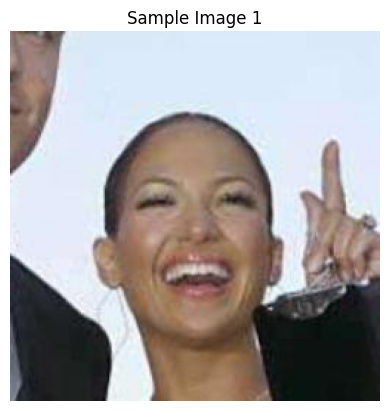

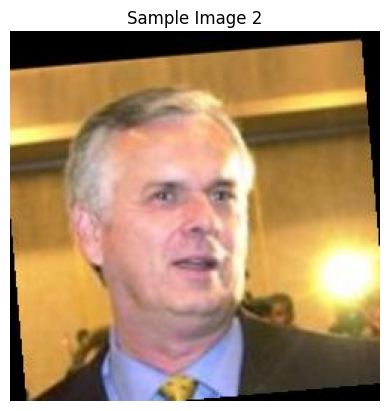

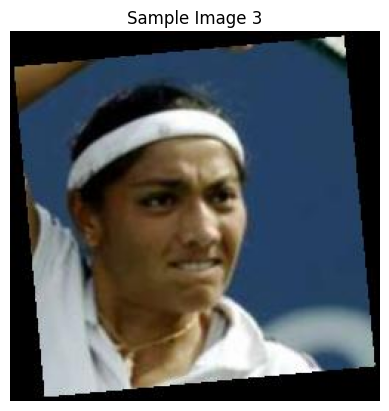

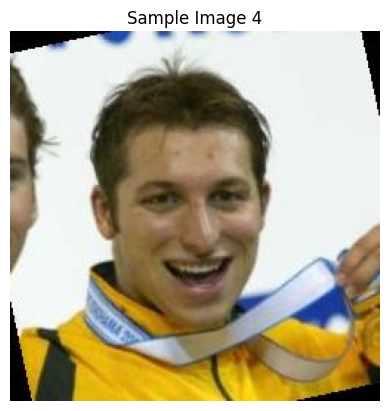

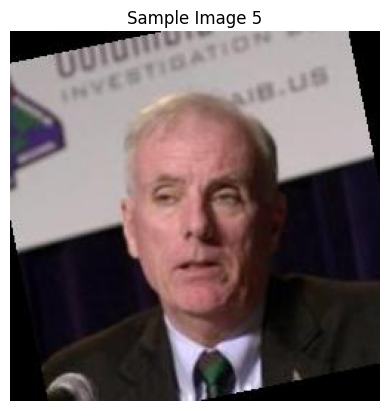

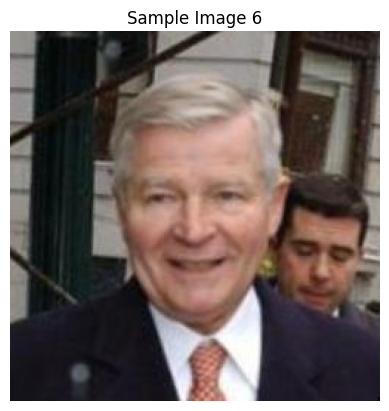

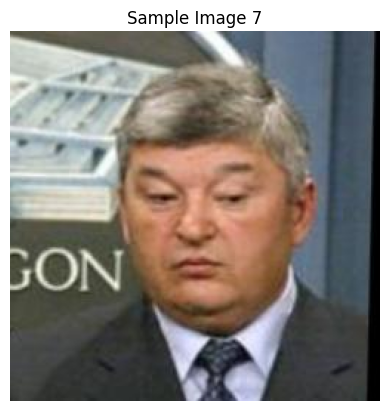

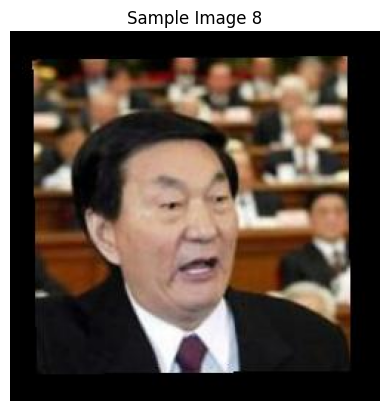

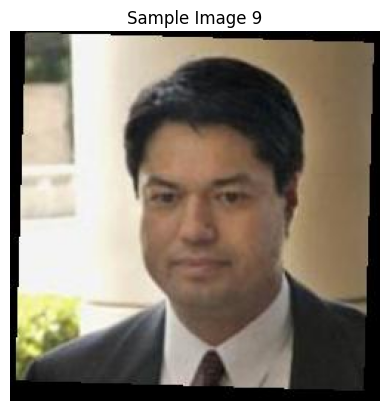

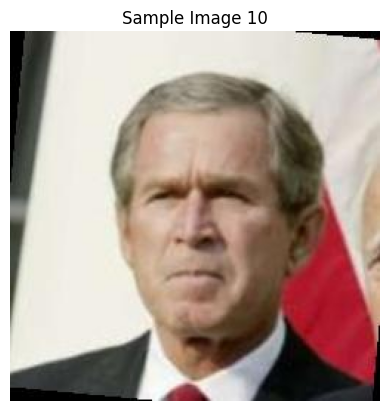

In [ ]:

import random
all_images_folder='/content/drive/MyDrive/all_images'
image_files=os.listdir(all_images_folder)

random_images=random.sample(image_files,10)
for i,image_name in enumerate(random_images,start=1):
  image_path=os.path.join(all_images_folder,image_name)
  img=Image.open(image_path)

  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Sample Image {i}')
  plt.show()


In [ ]:
len(image_files)

8874

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the folder where your images are stored
folder_path = "/content/drive/MyDrive/all_images"

# List all files in the directory (make sure they are image files)
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]


def resize_images(image_files, target_size=(80, 80)):
    resized_images = []
    for path in image_files:
        if not os.path.exists(path):  # Check if file exists
            print(f"File not found: {path}")
            continue
        try:
            img = load_img(path, target_size=target_size)  # Load and resize image
            img_array = img_to_array(img) / 255.0  # Convert to array and normalize
            resized_images.append(img_array)
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    return np.array(resized_images)

# Resize all images
print("Resizing images to 80x80...")
resized_images = resize_images(image_files)

# Check the shape of the resized images
print(f"Shape of resized images: {resized_images.shape}")


Resizing images to 80x80...
Shape of resized images: (8874, 80, 80, 3)


In [ ]:
print(len(resized_images))

8874


In [ ]:
np.save('resized_images.npy',resized_images)

In [ ]:
resized_images = np.load('resized_images.npy')

# Check the shape of the loaded images
print(f"Shape of loaded images: {resized_images.shape}")


Shape of loaded images: (8874, 80, 80, 3)


In [ ]:
train_x,val_x=train_test_split(resized_images,random_state=32,test_size=0.2)

In [ ]:
train_x.shape[0]

7099

In [ ]:
val_x.shape[0]

1775

In [ ]:
import cv2
import numpy as np

# Function to reduce resolution
def red_resolution(image, scale_factor):
    width = int(image.shape[1] * scale_factor / 100)
    height = int(image.shape[0] * scale_factor / 100)
    dim = (width, height)

    # Reduce the resolution
    reduced_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # Scale back to the original size
    low_res_image = cv2.resize(reduced_image, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    return low_res_image

# Apply the resolution reduction to train_x
train_x_low_res = np.array([red_resolution(img, scale_factor=35) for img in train_x])
val_x_low_res = np.array([red_resolution(img, scale_factor=35) for img in val_x])

# Print the shape to verify the changes
print(f"Shape of low_resolution training images is :{train_x_low_res.shape}")
print(f"Shape of low_resolution validation images is :{val_x_low_res.shape}")



Shape of low_resolution training images is :(7099, 80, 80, 3)
Shape of low_resolution validation images is :(1775, 80, 80, 3)


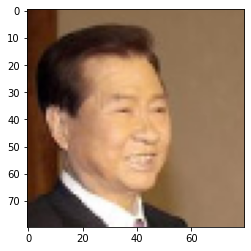

In [ ]:
plt.imshow(train_x[100])

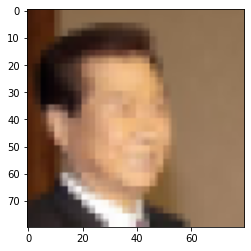

In [ ]:
plt.imshow(train_x_low_res[100])

In [ ]:

Input_img = Input(shape=(80, 80, 3))

#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [ ]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 80, 80, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 80, 80, 64)   36928       conv2d_98[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 40, 40, 64)   0           conv2d_99[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = autoencoder.fit(train_x_low_res,train_x,
            epochs=100,
            validation_data=(val_x_low_res, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
332/332 [==============================] - 20s 60ms/step - loss: 0.0086 - accuracy: 0.8445 - val_loss: 0.0029 - val_accuracy: 0.8912
Epoch 2/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0027 - accuracy: 0.8979 - val_loss: 0.0026 - val_accuracy: 0.9052
Epoch 3/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0025 - accuracy: 0.9053 - val_loss: 0.0025 - val_accuracy: 0.9113
Epoch 4/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0024 - accuracy: 0.9097 - val_loss: 0.0024 - val_accuracy: 0.9174
Epoch 5/100
332/332 [==============================] - 21s 63ms/step - loss: 0.0024 - accuracy: 0.9108 - val_loss: 0.0024 - val_accuracy: 0.9104
Epoch 6/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0023 - accuracy: 0.9135 - val_loss: 0.0023 - val_accuracy: 0.9173
Epoch 7/100
332/332 [==============================] - 21s 62ms/step - loss: 0.0023 - accuracy: 0.9146 - val_loss: 0.0023 - val_ac

In [ ]:
autoencoder = tf.keras.models.load_model('superResolution_checkpoint3.h5')

In [ ]:
predictions = autoencoder.predict(val_x_low_res)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


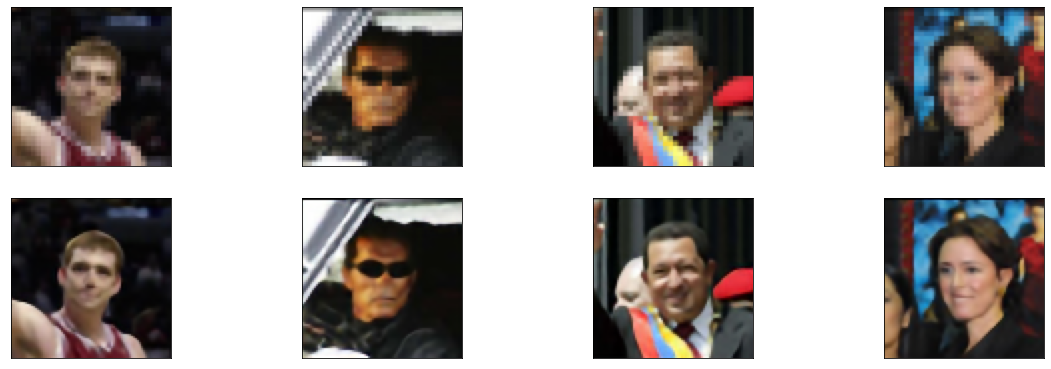

In [ ]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_low_res[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

In [ ]:
results = autoencoder.evaluate(val_x_low_res, val_x)
print('loss, accuracy', results)

83/83 [==============================] - 2s 20ms/step - loss: 0.0021 - accuracy: 0.9279
loss, accuracy [0.002111854264512658, 0.9279356002807617]


In [ ]:
img = image.load_img('download.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

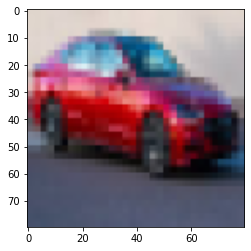

In [ ]:
img = red_resolution(img)
plt.imshow(img)

In [ ]:

input_array = np.array([img])

In [ ]:
predict = autoencoder.predict(input_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


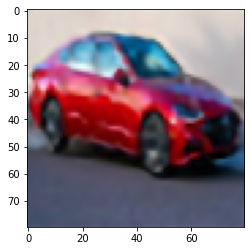

In [ ]:
plt.imshow(predict[0])